In [1]:
%matplotlib inline

from collections import OrderedDict
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm

/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
with open('seasons.pickle') as f:
    seasons = pickle.load(f)
for year, season in seasons.iteritems():
    print year,
    season.load_scores()

2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018


In [3]:
events = {}
for season in seasons.values():
    events.update(season.event_dict)

In [2]:
skaters = {}
for discipline in ('men', 'ladies', 'pairs', 'dance'):
    skaters[discipline] = pd.read_csv('pd_data/results_nowd_nofra15_' + discipline + '.csv')

In [5]:
with open('pd_data/name_fixes_all.json') as f:
    name_fixes = json.load(f)

In [69]:
# for discipline, df in skaters.iteritems():
#     df.to_csv('pd_data/results_nowd_nofra15_' + discipline + '.csv')

In [16]:
discipline = 'dance'

In [17]:
df_2017 = skaters[discipline][skaters[discipline].Season == 2017]
have_free = df_2017[df_2017['Free Start'].notnull()]

In [18]:
len(df_2017), len(df_2017.Name.unique())

(142, 57)

In [19]:
len(have_free), len(have_free.Name.unique())

(120, 46)

In [7]:
# only grab 2017 results where there are start orders
start_order = skaters['men'][skaters['men']['Short Start'].notnull()]
start_order17 = start_order[start_order.Season == 2017]
len(start_order17)

170

In [8]:
len(start_order17.Name.unique())

76

In [9]:
start_order17[:3]

,Unnamed: 0,Unnamed: 0.1,Date,Event,Free Rank,Free Score,Name,Nation,Points,Rank,Short Rank,Short Score,Num Short Scorecards,Num Free Scorecards,Short Start,Free Start,Season
1891,1891,0,2016-10-23,gpusa2016,1,190.19,Shoma UNO,JPN,279.34,1,1.0,89.15,10,10,9.0,9.0,2017
1892,1892,1,2016-10-23,gpusa2016,2,182.63,Jason BROWN,USA,268.38,2,3.0,85.75,10,10,8.0,10.0,2017
1893,1893,2,2016-10-23,gpusa2016,3,174.11,Adam RIPPON,USA,261.43,3,2.0,87.32,10,10,10.0,8.0,2017


In [10]:
history = skaters['men'][skaters['men'].Season != 2017]
len(history)

1891

In [11]:
individual_bests_short = {skater: np.max(map(float, history[history.Name == skater]['Short Score']))
                          for skater in history.Name.get_values()}
len(individual_bests_short)

281

In [12]:
have_frees = history[history['Free Rank'] != 'DNQ']
have_frees = have_frees[have_frees['Free Rank'] != 'WD']
individual_bests_free = {skater: np.max(map(float, have_frees[have_frees.Name == skater]['Free Score']))
                         for skater in have_frees.Name.get_values()}
len(individual_bests_free)

224

In [13]:
med_short = np.median(individual_bests_short.values())
med_free = np.median(individual_bests_free.values())
med_short, med_free

(60.810000000000002, 123.035)

In [14]:
start = []        # normalized start order b/w 0 and 1, closer to 1 is later
reputation = []   # maximum of historical total scores. if no history, then median of existing skaters'
score = []
skaters_short = []

start_free = []
reputation_free = []
score_free = []
skaters_free = []

for idx, row in start_order17.iterrows():
    start.append(row.loc['Short Start'] / float(row.loc['Num Short Scorecards']))
    if row.Name in individual_bests_short:
        reputation.append(individual_bests_short[row.Name])
    else:
        reputation.append(med_short)
    score.append(row.loc['Short Score'])
    skaters_short.append(row.loc['Name'])
    
    if pd.notnull(row.loc['Free Start']):
        start_free.append(row.loc['Free Start'] /  float(row.loc['Num Free Scorecards']))
        if row.Name in individual_bests_free:
            reputation_free.append(individual_bests_free[row.Name])
        else:
            reputation_free.append(med_free)
        score_free.append(row.loc['Free Score'])
        skaters_free.append(row.loc['Name'])

In [15]:
start_order17.Name.unique().size, len(start_order17)

(76, 170)

In [16]:
have_frees17 = start_order17[start_order17['Free Rank'] != 'DNQ']
have_frees17 = have_frees17[have_frees17['Free Rank'] != 'WD']
len(have_frees17.Name.unique())

62

In [17]:
len(start), len(reputation), len(score)

(170, 170, 170)

In [18]:
len(start_free), len(reputation_free), len(score_free)

(144, 144, 144)

In [19]:
# Model: short_score = reputation + start_order
X = pd.DataFrame({'Reputation': reputation}).astype(float) #, 'Start Number': start}).astype(float)
X = sm.add_constant(X)
y_short = pd.Series(score).astype(float)

In [20]:
mod_short = sm.OLS(y_short, X).fit()
print mod_short.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     222.2
Date:                Sun, 18 Mar 2018   Prob (F-statistic):           1.48e-32
Time:                        19:14:20   Log-Likelihood:                -624.90
No. Observations:                 170   AIC:                             1254.
Df Residuals:                     168   BIC:                             1260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1958      3.806      5.043      0.0

In [21]:
# sm.OLS(y_short, X).fit_regularized().summary()

In [27]:
outliers = mod_short.outlier_test()

In [28]:
outliers[outliers['bonf(p)'] < 0.8]

,student_resid,unadj_p,bonf(p)
24,3.076438,0.002527,0.358800
25,3.278955,0.001319,0.187265
109,-3.177197,0.001835,0.260606
127,2.853080,0.004997,0.709558


In [30]:
for index in (24, 25, 109, 127):
    print skaters_short[index], y_short[index]

 Tiffany ZAHORSKI / Jonathan GUERREIRO 64.28
Elliana POGREBINSKY / Alex BENOIT 62.93
Kimberley HEW-LOW / Timothy MCKERNAN 33.54
Olivia SMART / Adria DIAZ 60.93


In [22]:
skaters_short[56], skaters_short[104], skaters_short[108], skaters_short[139]

('Nathan CHEN', 'Daniel SAMOHIN', 'Nathan CHEN', 'Nathan CHEN')

In [27]:
score[104], score[108], score[139]

(50.33, 103.12, 97.33)

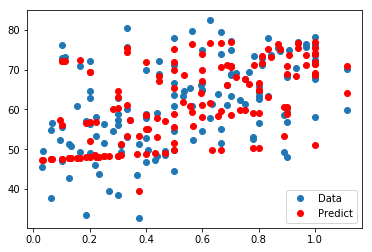

In [44]:
short_pred = mod_short.predict(X)
fig, ax = plt.subplots()
ax.plot(start, y_short, 'o', label="Data")
ax.plot(start, short_pred, 'ro', label='Predict')
ax.legend(loc="best")

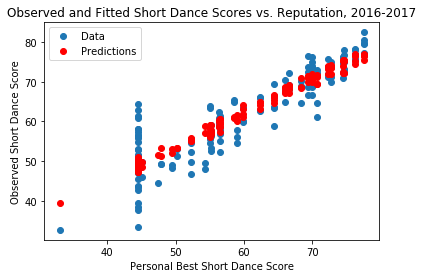

In [54]:
# fig, ax = plt.subplots()
plt.plot(reputation, y_short, 'o', label="Data")
plt.plot(reputation, short_pred, 'ro', label="Predictions")
plt.legend(loc="best")
plt.title('Observed and Fitted Short Dance Scores vs. Reputation, 2016-2017')
plt.xlabel('Personal Best Short Dance Score')
plt.ylabel('Observed Short Dance Score')

In [55]:
# Model: free_score = reputation + start_order
X_free = pd.DataFrame({'Reputation': reputation_free, 'Start Number': start_free}).astype(float)
X_free = sm.add_constant(X_free)
y_free = pd.Series(score_free).astype(float)

In [56]:
mod_free = sm.OLS(y_free, X_free).fit()
print mod_free.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     280.8
Date:                Thu, 15 Mar 2018   Prob (F-statistic):           2.18e-45
Time:                        13:24:46   Log-Likelihood:                -385.33
No. Observations:                 120   AIC:                             776.7
Df Residuals:                     117   BIC:                             785.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.5212      4.946      4.351   

In [57]:
outliers_free = mod_free.outlier_test()

In [58]:
outliers_free[outliers_free['bonf(p)'] < 0.8]

,student_resid,unadj_p,bonf(p)
97,-3.469185,7.335949e-04,0.088031
99,-5.251572,6.918374e-07,0.000083


In [60]:
print skaters_free[97], y_free[97]
print skaters_free[99], y_free[99], med_free

Adele MORRISON / Demid ROKACHEV 58.48
Kimberley HEW-LOW / Timothy MCKERNAN 51.43 78.62


In [31]:
start_order17[start_order17.Name == 'Julia LIPNITSKAIA']

,Unnamed: 0,Unnamed: 0.1,Date,Event,Free Rank,Free Score,Name,Nation,Points,Rank,Short Rank,Short Score,Num Short Scorecards,Num Free Scorecards,Short Start,Free Start,Season
2022,2022,11,2016-11-06,gprus2016,12,78.88,Julia LIPNITSKAIA,RUS,148.13,12,3,69.25,12,12,4.0,10.0,2017


In [30]:
skaters_free[33], score_free[33]

('Julia LIPNITSKAIA', '78.88')

In [34]:
skaters_free[2], score_free[2]

('Evgenia TARASOVA / Vladimir MOROZOV', '110.7')

In [36]:
individual_bests_free['Evgenia TARASOVA / Vladimir MOROZOV'], individual_bests_short['Evgenia TARASOVA / Vladimir MOROZOV']

(134.27000000000001, 72.0)

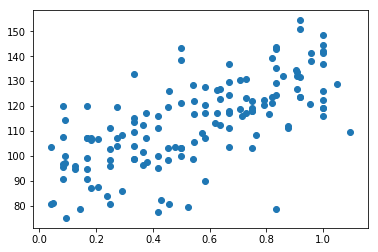

In [32]:
plt.scatter(start_free, score_free)

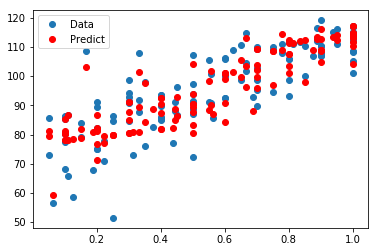

In [62]:
free_pred = mod_free.predict(X_free)
plt.plot(start_free, y_free, 'o', label="Data")
plt.plot(start_free, free_pred, 'ro', label='Predict')
plt.legend(loc="best")

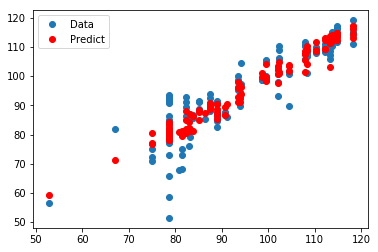

In [63]:
plt.plot(reputation_free, y_free, 'o', label="Data")
plt.plot(reputation_free, free_pred, 'ro', label="Predict")
plt.legend(loc="best")

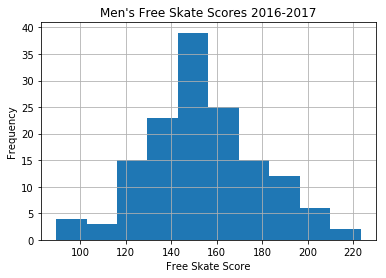

In [32]:
y_free.hist()
plt.title('Men\'s Free Skate Scores 2016-2017')
plt.ylabel('Frequency')
plt.xlabel('Free Skate Score')

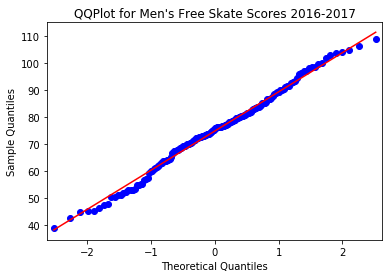

In [33]:
sm.qqplot(y_short, line='s')
plt.title('QQPlot for Men\'s Free Skate Scores 2016-2017')

In [38]:
print sm.stats.diagnostic.kstest_normal(y_short)[1]
print sm.stats.diagnostic.kstest_normal(y_free)[1]
print sm.stats.diagnostic.kstest_normal(skaters['men'].Points)[1]

0.442679316173
0.141371894957
3.11851322514e-128


In [ ]:
# LET'S TRY JUST THE LAST TWO PERFORMANCES.

In [127]:
short_hist = {skater: list(history[history.Name == skater]['Short Score'][-2:])
              for skater in history.Name.get_values()}
free_hist = {skater: list(have_frees[have_frees.Name == skater]['Free Score'][-2:])
             for skater in have_frees.Name.get_values()}
for skater in short_hist:
    while len(short_hist[skater]) < 2:
        short_hist[skater].append(0.)
for skater in free_hist:
    while len(free_hist[skater]) < 2:
        free_hist[skater].append(0.)

In [128]:
prev_short_1 = []
prev_short_2 = []
short_score = []

prev_free_1 = []
prev_free_2 = []
free_score = []

for idx, row in start_order17.iterrows():
    if row.Name in short_hist:
        prev_short_1.append(short_hist[row.Name][0])
        prev_short_2.append(short_hist[row.Name][1])
    else:
        prev_short_1.append(0.)
        prev_short_2.append(0.)
    short_score.append(row.loc['Short Score'])
    
    if pd.notnull(row.loc['Free Start']):
        if row.Name in free_hist:
            prev_free_1.append(free_hist[row.Name][0])
            prev_free_2.append(free_hist[row.Name][1])
        else:
            prev_free_1.append(0.)
            prev_free_2.append(0.)
        free_score.append(row.loc['Free Score'])

In [131]:
# Model: short_score = last short score + short score before that
X_short = pd.DataFrame({'Last Score': prev_short_1, 'Last Last Score': prev_short_2, # 'Start': start,
                        'Reputation': reputation}).astype(float)
X_short = sm.add_constant(X_short)
y_short = pd.Series(short_score).astype(float)
mod_short = sm.OLS(y_short, X_short).fit()
print mod_short.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     33.34
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           2.71e-15
Time:                        22:50:17   Log-Likelihood:                -377.10
No. Observations:                 111   AIC:                             762.2
Df Residuals:                     107   BIC:                             773.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               8.9139      6.695     

In [37]:
# Model: free_score = last free score + free score before that
X_free = pd.DataFrame({'Last Score': prev_free_1, 'Last Last Score': prev_free_2, 'Start': start_free,
                       'Reputation': reputation_free}).astype(float)
X_free = sm.add_constant(X_free)
y_free = pd.Series(free_score).astype(float)
mod_free = sm.OLS(y_free, X_free).fit()
print mod_free.summary()

In [42]:
# 2018 data
men = []
ladies = []
pairs = []
dance = []
skaters18 = [men, ladies, pairs, dance]
for event in season18.events:
    for i, discipline in enumerate(event.disciplines):
        df = pd.read_csv(discipline.results_csv)
        skaters18[i].append(df)
men = pd.concat(men)
ladies = pd.concat(ladies)
pairs = pd.concat(pairs)
dance = pd.concat(dance)

In [43]:
skaters18 = {'men': men, 'ladies': ladies, 'pairs': pairs, 'dance': dance}

In [44]:
ind_best_shorts = {}
for skater in skaters['ladies'].Name.get_values():
    ind_best_shorts[skater] = np.max(skaters['ladies'][skaters['ladies'].Name == skater]['Short Score'])
med_short = np.median(ind_best_shorts.values())

In [45]:
hist_free = skaters['ladies'][skaters['ladies']['Free Rank'] != 'DNQ']
hist_free = hist_free[hist_free['Free Rank'] != 'WD']
ind_best_frees = {}
for skater in hist_free.Name.get_values():
    ind_best_frees[skater] = np.max(map(float, hist_free[hist_free.Name == skater]['Free Score']))
med_free = np.median(ind_best_frees.values())
# ind_best_frees = {skaters: np.max(hist_free[hist_free.Name == skater]['Free Score'])
#                   for skater in hist_free.Name.get_values()}

In [49]:
def get_start(row, discipline_i, segment_i, segment_rank_name):
    if row[segment_rank_name] == 'WD' or row[segment_rank_name] == 'DNQ':
        return None
    start = events[row.Event].disciplines[discipline_i].segments[segment_i].scorecards[int(row[segment_rank_name])-1].starting_number
    if start == 0:
        return None
    return start

In [50]:
def get_start(row, discipline_i, segment_i, segment_rank_name):
    if row[segment_rank_name] == 'WD' or row[segment_rank_name] == 'DNQ':
        return None
    start = events[row.Event].disciplines[discipline_i].segments[segment_i].scorecards[int(row[segment_rank_name])-1].starting_number
    if start == 0:
        return None
    return start

In [51]:
for i, discipline in enumerate(('men', 'ladies', 'pairs', 'dance')):
    print i, discipline
    skaters18[discipline]['Short Start'] = skaters18[discipline].apply(lambda row: get_start(row, i, 0, 'Short Rank'), axis=1)
    skaters18[discipline]['Free Start'] = skaters18[discipline].apply(lambda row: get_start(row, i, 1, 'Free Rank'), axis=1)
    skaters18[discipline]['Num Short Scorecards'] = skaters18[discipline].apply(lambda row: len(events[row.Event].disciplines[i].segments[0].scorecards), axis=1)
    skaters18[discipline]['Num Free Scorecards'] = skaters18[discipline].apply(lambda row: len(events[row.Event].disciplines[i].segments[1].scorecards), axis=1)

0 men
1 ladies
2 pairs
3 dance


In [46]:
med_short, med_free

(47.325000000000003, 93.944999999999993)

In [52]:
start = []        # normalized start order b/w 0 and 1, closer to 1 is later
reputation = []   # maximum of historical total scores. if no history, then median of existing skaters'
score = []

start_free = []
reputation_free = []
score_free = []

for idx, row in skaters18['ladies'].iterrows():
    start.append(row.loc['Short Start'] / float(row.loc['Num Short Scorecards']))
    if row.Name in ind_best_shorts:
        reputation.append(ind_best_shorts[row.Name])
    else:
        reputation.append(med_short)
    score.append(row.loc['Short Score'])
    
    if pd.notnull(row.loc['Free Start']):
        start_free.append(row.loc['Free Start'] /  float(row.loc['Num Free Scorecards']))
        if row.Name in ind_best_frees:
            reputation_free.append(ind_best_frees[row.Name])
        else:
            reputation_free.append(med_free)
        score_free.append(row.loc['Free Score'])

score_free = map(float, score_free)
score_short = map(float, score)

In [53]:
len(start), len(reputation), len(score)

(137, 137, 137)

In [54]:
len(start_free), len(reputation_free), len(score_free)

(121, 121, 121)

In [55]:
b0_short = 21.8275 # 20.8236
brep_short = 0.5289 # 0.6155
bstart_short = 10.5243 # 12.3222

In [56]:
b0_free = 71.8259 # 72.3915
brep_free = 0.1939 # 0.3983
bstart_free = 35.1033 # 35.2871

In [57]:
short_pred = map(lambda (sn, rep): b0_short + brep_short * rep + bstart_short * sn, zip(start, reputation))
free_pred = map(lambda (sn, rep): b0_free + brep_free * rep + bstart_free * sn, zip(start_free, reputation_free))

In [59]:
with open('fits/ladies_reputation_start_pred.csv', 'w') as f:
    pickle.dump((short_pred, free_pred), f)

In [60]:
shortx = list(xrange(len(score_short)))
longx = list(xrange(len(score_free)))

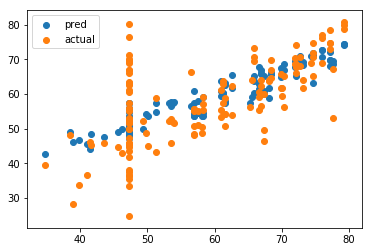

In [61]:
plt.scatter(reputation, short_pred, label="pred")
plt.scatter(reputation, score, label="actual")
plt.legend()
plt.show()

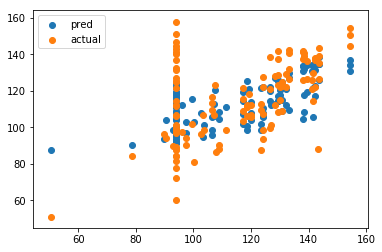

In [62]:
plt.scatter(reputation_free, free_pred, label="pred")
plt.scatter(reputation_free, score_free, label="actual")
plt.legend()
plt.show()

In [63]:
sum(map(lambda (x,y): (x-y) * (x-y), zip(score, short_pred)))

10183.096897197431

In [64]:
sum(map(lambda (x,y): (x-y) * (x-y), zip(score_free, free_pred)))

30021.538102775627

In [13]:
# MED TES AND MAX PCS AS SEPARATE VARIABLES
hist_tes_short = {skater: np.median(map(float, history[history.Name == skater]['Short TES']))
                  for skater in history.Name.get_values()}
hist_pcs_short = {skater: np.median(map(float, history[history.Name == skater]['Short PCS']))
                  for skater in history.Name.get_values()}
med_tes_short = np.median(hist_tes_short.values())
med_pcs_short = np.median(hist_pcs_short.values())
med_tes_short, med_pcs_short

(26.68, 22.170000000000002)

In [14]:
have_frees = history[history['Free Rank'] != 'DNQ']
have_frees = have_frees[have_frees['Free Rank'] != 'WD']
hist_tes_free = {skater: np.median(map(float, have_frees[have_frees.Name == skater]['Free TES']))
                 for skater in have_frees.Name.get_values()}
hist_pcs_free = {skater: np.median(map(float, have_frees[have_frees.Name == skater]['Free PCS']))
                 for skater in have_frees.Name.get_values()}
med_tes_free = np.median(hist_tes_free.values())
med_pcs_free = np.median(hist_pcs_free.values())
med_tes_free, med_pcs_free

(47.259999999999998, 45.200000000000003)

In [15]:
start_short = []  # normalized start order b/w 0 and 1, closer to 1 is later
tes_short = []    # average short TES in history 
pcs_short = []    # max short PCS in history
score_short = []
skaters_short = []

start_free = []
tes_free = []
pcs_free = []
score_free = []
skaters_free = []

for idx, row in start_order17.iterrows():
    start_short.append(row.loc['Short Start'] / float(row.loc['Num Short Scorecards']))
    if row.Name in hist_tes_short:
        tes_short.append(hist_tes_short[row.Name])
        pcs_short.append(hist_pcs_short[row.Name])
    else:
        tes_short.append(med_tes_short)
        pcs_short.append(med_pcs_short)
    score_short.append(row.loc['Short Score'])
    skaters_short.append(row.loc['Name'])
    
    if pd.notnull(row.loc['Free Start']):
        start_free.append(row.loc['Free Start'] /  float(row.loc['Num Free Scorecards']))
        if row.Name in hist_tes_free:
            tes_free.append(hist_tes_free[row.Name])
            pcs_free.append(hist_pcs_free[row.Name])
        else:
            tes_free.append(med_tes_free)
            pcs_free.append(med_pcs_free)
        score_free.append(row.loc['Free Score'])
        skaters_free.append(row.loc['Name'])

In [16]:
len(start_free), len(tes_free), len(pcs_free), len(score_free)

(97, 97, 97, 97)

In [17]:
# Model: short_score = historical avg TES + historical max PCS + start_order
# X_short = pd.DataFrame({'Reputation': map(lambda (tes, pcs): tes + pcs, zip(tes_short, pcs_short)),
#                         'Start Number': start_short}).astype(float)
X_short = pd.DataFrame({'Avg TES': tes_short, 'Max PCS': pcs_short, 'Start Number': start_short}).astype(float)
X_short = sm.add_constant(X_short)
y_short = pd.Series(score_short).astype(float)
mod_short = sm.OLS(y_short, X_short).fit()
print mod_short.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     38.91
Date:                Wed, 07 Feb 2018   Prob (F-statistic):           4.39e-17
Time:                        19:02:16   Log-Likelihood:                -372.78
No. Observations:                 111   AIC:                             753.6
Df Residuals:                     107   BIC:                             764.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           26.7677      4.889      5.475   

In [109]:
# Model: short_score = historical avg TES + historical max PCS + start_order
X_free = pd.DataFrame({'Reputation': map(lambda (tes, pcs): tes + pcs, zip(tes_free, pcs_free)),
                        'Start Number': start_free}).astype(float)
# X_free = pd.DataFrame({'Avg TES': tes_free, 'Max PCS': pcs_free, 'Start Number': start_free}).astype(float)
X_free = sm.add_constant(X_free)
y_free = pd.Series(score_free).astype(float)
mod_free = sm.OLS(y_free, X_free).fit()
print mod_free.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     86.12
Date:                Mon, 05 Feb 2018   Prob (F-statistic):           5.61e-22
Time:                        20:17:02   Log-Likelihood:                -360.95
No. Observations:                  97   AIC:                             727.9
Df Residuals:                      94   BIC:                             735.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           47.5096      8.111      5.857   

In [94]:
out_short = mod_short.outlier_test()
out_short[out_short['bonf(p)'] < 0.5]

,student_resid,unadj_p,bonf(p)


In [96]:
out_free = mod_free.outlier_test()
out_free[out_free['bonf(p)'] < 0.8]

,student_resid,unadj_p,bonf(p)
2,-3.206057,0.001851,0.179546


In [97]:
skaters_free[2]

'Evgenia TARASOVA / Vladimir MOROZOV'

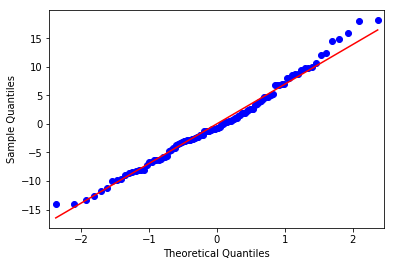

In [98]:
sm.qqplot(mod_short.resid, line='s')  # Residuals are fairly normal.

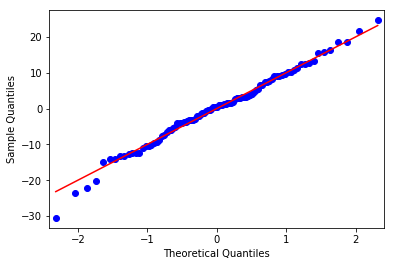

In [99]:
sm.qqplot(mod_free.resid, line='s')

In [100]:
sm.stats.diagnostic.kstest_normal(mod_short.resid)

(0.067784701993240271, 0.22104820555555219)

In [101]:
sm.stats.diagnostic.kstest_normal(mod_free.resid)

(0.065134222324900404, 0.35873570149551709)

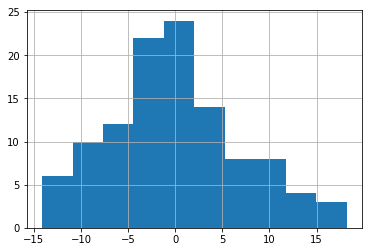

In [104]:
mod_short.resid.hist()
plt.show()

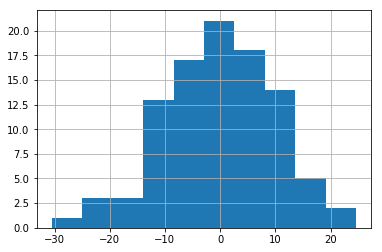

In [105]:
mod_free.resid.hist()
plt.show()

In [134]:
skaters['pairs'] = skaters['pairs'].drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [18]:
pair_totals = skaters['pairs'][['Date', 'Event', 'Name', 'Nation', 'Points', 'Rank', 'Short Rank', 'Short Score', 'Free Rank', 'Free Score']]

In [19]:
pair_totals[:3]

,Date,Event,Name,Nation,Points,Rank,Short Rank,Short Score,Free Rank,Free Score
0,2005-10-23,gpusa05,Dan ZHANG / Hao ZHANG,CHN,179.14,1,1,59.90,1,119.24
1,2005-10-23,gpusa05,Rena INOUE / John BALDWIN,USA,164.44,2,3,54.84,2,109.6
2,2005-10-23,gpusa05,Julia OBERTAS / Sergei SLAVNOV,RUS,160.40,3,4,54.04,4,106.36


In [20]:
event_results = []
for event in season18.events:
    discipline = event.disciplines[2]
    event_results.append(pd.read_csv(discipline.results_csv))

In [21]:
all_hist = pd.concat([pair_totals] + event_results)

In [22]:
with open('pd_data/name_fixes_pairs.json') as f:
    pair_name_fixes = f.read()
pair_name_fixes = json.loads(pair_name_fixes)

In [25]:
for wrong, right in pair_name_fixes.iteritems():
    all_hist.loc[all_hist.Name == wrong, 'Name'] = right

/anaconda/lib/python2.7/site-packages/pandas/core/ops.py:739: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)


In [29]:
sorted(all_hist.Name.unique())

['Adel TANKOVA / Evgeni KRASNOPOLSKI',
 'Adeline CANAC / Maximin COIA',
 'Adeline CANAC / Yannick BONHEUR',
 'Alessandra CERNUSCHI / Filippo AMBROSINI',
 'Alexa SCIMECA KNIERIM / Chris KNIERIM',
 'Alexandra HERBRIKOVA / Nicolas ROULET',
 'Alexandra HERBRIKOVA / Rudy HALMAERT',
 'Alexandra MALAKHOVA / Leri KENCHADZE',
 'Alina DIKHTIAR / Filip ZALEVSKI',
 'Aliona SAVCHENKO / Robin SZOLKOWY',
 'Alisa EFIMOVA / Alexander KOROVIN',
 u'Aljona SAVCHENKO / Bruno MASSOT',
 'Amanda EVORA / Mark LADWIG',
 'Amanda SUNYOTO-YANG / Darryll SULNDRO-YANG',
 'Amanda VELENOSI / Mark FERNANDEZ',
 'Amani FANCY / Christopher BOYADJI',
 'Amy IRELAND / Michael BAHORIC',
 'Anabelle LANGLOIS / Cody HAY',
 'Anais MORAND / Antoine DORSAZ',
 'Anais MORAND / Timothy LEEMANN',
 'Anastasia MARTIUSHEVA / Alexei ROGONOV',
 'Andrea DAVIDOVICH / Evgeni KRASNOPOLSKI',
 'Angelika PYLKINA / Niklas HOGNER',
 'Anna DUSKOVA / Martin BIDAR',
 'Anna KHNYCHENKOVA / Mark MAGYAR',
 'Anna Marie PEARCE / Mark MAGYAR',
 'Annabelle PR\

In [30]:
pair18 = pd.read_csv('pair18.csv')

In [31]:
pair18.columns

Index([u'Unnamed: 0', u'Rank', u'Event', u'Date', u'Name', u'Nation',
       u'Points', u'Short Rank', u'Short Score', u'Free Rank', u'Free Score',
       u'Prev Prev', u' Prev'],
      dtype='object')

In [32]:
y = pair18.Points.astype(float)
X = pair18[['Prev Prev', ' Prev']]
X = sm.add_constant(X)

In [33]:
mod = sm.OLS(y, X).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     59.77
Date:                Wed, 07 Feb 2018   Prob (F-statistic):           1.02e-14
Time:                        19:03:39   Log-Likelihood:                -244.96
No. Observations:                  60   AIC:                             495.9
Df Residuals:                      57   BIC:                             502.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        129.6809      6.166     21.031      0.0

In [35]:
pair_entries = [
    'Ekaterina ' + 'Alexandrovskaya'.upper() + ' / Harley ' + 'Windsor'.upper(),
    'Miriam ZIEGLER / Severin KIEFER',
    'Meagan DUHAMEL / Eric RADFORD',
    'Kirsten MOORE-TOWERS / Michael MARINARO',
    'Julianne SEGUIN / Charlie BILODEAU',
    'Cheng PENG / Yang JIN',
    'Wenjing SUI / Cong HAN',
    'Xiaoyu YU / Hao ZHANG',
    'Anna DUSKOVA / Martin BIDAR',
    'Vanessa JAMES / Morgan CIPRES',
#     'Annika HOCKE / Ruben BLOMMAERT',
    'Aljona SAVCHENKO / Bruno MASSOT',
#     'Paige CONNERS / Evgeni KRASNOPOLSKI',
    'Nicole DELLA MONICA / Matteo GUARISE',
    'Valentina MARCHEI / Ondrej HOTAREK',
    'Miu SUZAKI / Ryuichi KIHARA',
    'Tae Ok RYOM / Ju Sik KIM',
    'Evgenia TARASOVA / Vladimir MOROZOV',
    'Ksenia STOLBOVA / Fedor KLIMOV',
    'Natalia ZABIIAKO / Alexander ENBERT',
    'Kyueun KIM / Alex Kang Chan KAM',
    'Alexa SCIMECA KNIERIM / Chris KNIERIM'
]

In [37]:
for entry in pair_entries:
    if entry not in all_hist.Name.unique():
        print entry

In [38]:
data = {}
for entry in pair_entries:
    data[entry] = list(all_hist[all_hist.Name == entry].Points[-2:].astype(float))
    while len(data[entry]) != 2:
        data[entry] = [0] + data[entry]

In [39]:
prev = []
prevprev = []
pairs = []
for entry, hist in data.iteritems():
    pairs.append(entry)
    prev.append(hist[1])
    prevprev.append(hist[0])

In [40]:
data

{'Alexa SCIMECA KNIERIM / Chris KNIERIM': [192.50999999999999,
  189.06999999999999],
 'Aljona SAVCHENKO / Bruno MASSOT': [223.13, 236.68000000000001],
 'Anna DUSKOVA / Martin BIDAR': [189.09, 179.69999999999999],
 'Cheng PENG / Yang JIN': [182.5, 188.13999999999999],
 'Ekaterina ALEXANDROVSKAYA / Harley WINDSOR': [164.09999999999999,
  178.10000000000005],
 'Evgenia TARASOVA / Vladimir MOROZOV': [208.72999999999999,
  221.59999999999999],
 'Julianne SEGUIN / Charlie BILODEAU': [186.16, 194.37],
 'Kirsten MOORE-TOWERS / Michael MARINARO': [194.52000000000001, 187.81],
 'Ksenia STOLBOVA / Fedor KLIMOV': [209.25999999999999, 211.00999999999999],
 'Kyueun KIM / Alex Kang Chan KAM': [0, 118.91],
 'Meagan DUHAMEL / Eric RADFORD': [215.68000000000001, 210.83000000000001],
 'Miriam ZIEGLER / Severin KIEFER': [171.13, 181.75],
 'Miu SUZAKI / Ryuichi KIHARA': [139.98000000000002, 157.26999999999995],
 'Natalia ZABIIAKO / Alexander ENBERT': [197.88999999999999,
  210.18000000000001],
 'Nicole DE

In [41]:
olyX = pd.DataFrame({' Prev': prev, 'Prev Prev': prevprev}).astype(float)
olyX = sm.add_constant(olyX)
predictions = mod.predict(olyX)

In [42]:
results = {}
for i, pair in enumerate(pairs):
    results[pair] = predictions[i]

In [44]:
for pair in sorted(results, key=lambda x: -results.get(x)):
    print pair, results[pair]

Wenjing SUI / Cong HAN 214.357397234
Aljona SAVCHENKO / Bruno MASSOT 212.775475004
Xiaoyu YU / Hao ZHANG 207.53298056
Evgenia TARASOVA / Vladimir MOROZOV 207.441820121
Meagan DUHAMEL / Eric RADFORD 207.327852979
Vanessa JAMES / Morgan CIPRES 206.937946329
Ksenia STOLBOVA / Fedor KLIMOV 205.978127096
Natalia ZABIIAKO / Alexander ENBERT 203.416618411
Nicole DELLA MONICA / Matteo GUARISE 200.701065321
Valentina MARCHEI / Ondrej HOTAREK 200.407517107
Kirsten MOORE-TOWERS / Michael MARINARO 199.362134512
Alexa SCIMECA KNIERIM / Chris KNIERIM 199.118834205
Julianne SEGUIN / Charlie BILODEAU 198.546717977
Anna DUSKOVA / Martin BIDAR 196.989920445
Cheng PENG / Yang JIN 196.834033631
Tae Ok RYOM / Ju Sik KIM 193.60814975
Miriam ZIEGLER / Severin KIEFER 193.444388255
Ekaterina ALEXANDROVSKAYA / Harley WINDSOR 191.393408938
Miu SUZAKI / Ryuichi KIHARA 183.1192164
Kyueun KIM / Alex Kang Chan KAM 147.392036896
